# IMPORTS

In [388]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso
%pip install catboost
import catboost as cb
import pickle

# CONFIGURACION

In [389]:
# Ajustar la configuración de pandas para mostrar más filas y columnas

#pd.set_option('display.max_rows', None)  # Mostrar todas las filas
#pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
#pd.set_option('display.float_format', '${:,.2f}'.format)  # Formato de números en la tabla

# LECTURA DE ARCHIVOS

In [390]:
archivo = "inmuebles.csv"

In [391]:
df_inmueble = pd.read_csv(archivo)

<ipython-input-391-e8e6ec971209>:1: DtypeWarning: Columns (4,5,6,7,8,13,14,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_inmueble = pd.read_csv(archivo)


In [392]:
df_inmueble.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,gimnasio,hidromasaje,parrilla,permite_mascotas,pileta,sala_de_juegos,solarium,uso_comercial,amoblado.1,acceso_movilidad_reducida
0,USD 800.000,$ 60.000,DOBLAS 955,"Caballito, Capital Federal",50,49,2,1,1,4 años,...,True,NaN,True,NaN,True,True,True,True,NaN,True
1,USD 700.000,$ 235.000,MANUEL UGARTE 2400. Entre Esquina ciudad de la...,"Belgrano, Capital Federal",65,59,3,2,2,19 años,...,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
2,USD 700.000,NaN,Mendoza,"Villa Urquiza, Capital Federal",74,74,2,2,1,40 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USD 550.000,$ 78.000,French 3031,"Recoleta, Capital Federal",41,37,2,1,1,12 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USD 550.000,$ 65.000,Malabia al 100,"Villa Crespo, Capital Federal",64,58,3,1,2,A estrenar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# ANALISIS EXPLORATORIO

## Conversion de monedas (USD)

In [393]:
valor_dolar = 1000

### Operaciones en dolares

#### Precio

In [394]:
df_inmueble = df_inmueble.dropna(subset=['precio'])
df_usd = df_inmueble[df_inmueble['precio'].str.contains('^USD', regex=True)]

In [395]:
df_usd.loc[:, 'precio'] = df_usd['precio'].str.replace('USD', '').str.replace('.', '').astype(float)

#### Expensas

In [396]:
df_usd.loc[:, 'expensas'] = df_usd['expensas'].str.replace('$', '').str.replace('.', '').astype(float)

In [397]:
df_usd.loc[:, 'expensas'] = df_usd['expensas'] / valor_dolar

In [398]:
df_usd.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,gimnasio,hidromasaje,parrilla,permite_mascotas,pileta,sala_de_juegos,solarium,uso_comercial,amoblado.1,acceso_movilidad_reducida
0,800000.0,60.0,DOBLAS 955,"Caballito, Capital Federal",50,49,2,1,1,4 años,...,True,NaN,True,NaN,True,True,True,True,NaN,True
1,700000.0,235.0,MANUEL UGARTE 2400. Entre Esquina ciudad de la...,"Belgrano, Capital Federal",65,59,3,2,2,19 años,...,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
2,700000.0,NaN,Mendoza,"Villa Urquiza, Capital Federal",74,74,2,2,1,40 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,550000.0,78.0,French 3031,"Recoleta, Capital Federal",41,37,2,1,1,12 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550000.0,65.0,Malabia al 100,"Villa Crespo, Capital Federal",64,58,3,1,2,A estrenar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Operaciones en pesos

#### Precio

In [399]:
df_ars = df_inmueble[df_inmueble['precio'].str.contains('^\$', regex=True)]

In [400]:
df_dolarizado = df_ars.copy()
df_dolarizado['precio'] = df_dolarizado['precio'].str.replace('$', '').str.replace('.', '')

def es_float(valor):
    try:
        float(valor)
        return True
    except ValueError:
        return False

# Elimino aquellos registros que no se puedan castear. Por ejemplo si incluyen otro simbolo de otra moneda.
df_dolarizado = df_dolarizado[df_dolarizado['precio'].apply(es_float)]

df_dolarizado['precio'] = df_dolarizado['precio'].astype(float)

df_dolarizado['precio'] = df_dolarizado['precio'] / valor_dolar

#### Expensas

In [401]:
df_dolarizado.loc[:, 'expensas'] = df_dolarizado['expensas'].str.replace('$', '').str.replace('.', '').astype(float)

In [402]:
df_dolarizado.loc[:, 'expensas'] = df_dolarizado['expensas'] / valor_dolar

In [403]:
df_dolarizado.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,gimnasio,hidromasaje,parrilla,permite_mascotas,pileta,sala_de_juegos,solarium,uso_comercial,amoblado.1,acceso_movilidad_reducida
233,5000.0,440.0,Quintana al 400,"Recoleta, Capital Federal",200,NaN,5,2,4,63 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
251,4850.0,120.0,Av. Azucena Villaflor 489,"Puerto Madero, Capital Federal",160,150,3,2,2,13 años,...,True,NaN,NaN,NaN,True,NaN,True,NaN,NaN,NaN
252,4600.0,164.0,Av. Libertador 5400. Entre Virrey del pino y V...,"Belgrano, Capital Federal",260,240,7,5,6,60 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,4500.0,NaN,AV. Corrientes Abasto - Local 3 al 3400,"Abasto, Capital Federal",230,210,NaN,2,NaN,En construcción,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,4000.0,25.0,Monoambiente en alquiler en San Cristobal 2200,"San Cristobal, Capital Federal",41,NaN,NaN,NaN,NaN,A estrenar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN


### Resultado

In [404]:
df_inmuebles_dolarizado = pd.concat([df_usd, df_dolarizado], axis=0)

In [405]:
df_inmuebles_dolarizado.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,gimnasio,hidromasaje,parrilla,permite_mascotas,pileta,sala_de_juegos,solarium,uso_comercial,amoblado.1,acceso_movilidad_reducida
0,800000.0,60.0,DOBLAS 955,"Caballito, Capital Federal",50,49,2,1,1,4 años,...,True,NaN,True,NaN,True,True,True,True,NaN,True
1,700000.0,235.0,MANUEL UGARTE 2400. Entre Esquina ciudad de la...,"Belgrano, Capital Federal",65,59,3,2,2,19 años,...,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
2,700000.0,NaN,Mendoza,"Villa Urquiza, Capital Federal",74,74,2,2,1,40 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,550000.0,78.0,French 3031,"Recoleta, Capital Federal",41,37,2,1,1,12 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550000.0,65.0,Malabia al 100,"Villa Crespo, Capital Federal",64,58,3,1,2,A estrenar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Eliminacion de duplicados

In [406]:
df_inmuebles_dolarizado.drop_duplicates(inplace=True)

## Unificacion columna Laundry / Lavadero / Lavarropas / Secarropas

In [407]:
# Opcion 1: si alguno de los 4 es verdadero la columna es verdadera
#df_inmuebles_dolarizado['limpieza_de_ropa'] = df_inmuebles_dolarizado['laundry'] | df_inmuebles_dolarizado['lavadero'] | df_inmuebles_dolarizado['lavarropas'] | df_inmuebles_dolarizado['secarropas']

In [408]:
# Opcion 2: sumo todos los que sean verdaderos
df_inmuebles_dolarizado[['laundry', 'lavadero', 'lavarropas', 'secarropas']] = df_inmuebles_dolarizado[['laundry', 'lavadero', 'lavarropas', 'secarropas']].notna().astype(int)

df_inmuebles_dolarizado['limpieza_de_ropa'] = df_inmuebles_dolarizado[['laundry', 'lavadero', 'lavarropas', 'secarropas']].sum(axis=1)

In [409]:
df_inmuebles_dolarizado.drop(['laundry', 'lavadero','lavarropas','secarropas'], axis=1, inplace=True)

In [410]:
df_inmuebles_dolarizado.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,hidromasaje,parrilla,permite_mascotas,pileta,sala_de_juegos,solarium,uso_comercial,amoblado.1,acceso_movilidad_reducida,limpieza_de_ropa
0,800000.0,60.0,DOBLAS 955,"Caballito, Capital Federal",50,49,2,1,1,4 años,...,NaN,True,NaN,True,True,True,True,NaN,True,1
1,700000.0,235.0,MANUEL UGARTE 2400. Entre Esquina ciudad de la...,"Belgrano, Capital Federal",65,59,3,2,2,19 años,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,1
2,700000.0,NaN,Mendoza,"Villa Urquiza, Capital Federal",74,74,2,2,1,40 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,550000.0,78.0,French 3031,"Recoleta, Capital Federal",41,37,2,1,1,12 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,550000.0,65.0,Malabia al 100,"Villa Crespo, Capital Federal",64,58,3,1,2,A estrenar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Equipamiento de cocina

In [411]:
df_inmuebles_dolarizado[['cocina_equipada', 'frigobar', 'microondas']] = df_inmuebles_dolarizado[['cocina_equipada', 'frigobar', 'microondas']].notna().astype(int)

df_inmuebles_dolarizado['equipamiento_de_cocina'] = df_inmuebles_dolarizado[['cocina_equipada', 'frigobar', 'microondas']].sum(axis=1)

In [412]:
df_inmuebles_dolarizado.drop(['cocina_equipada', 'frigobar','microondas'], axis=1, inplace=True)

In [413]:
df_inmuebles_dolarizado.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,parrilla,permite_mascotas,pileta,sala_de_juegos,solarium,uso_comercial,amoblado.1,acceso_movilidad_reducida,limpieza_de_ropa,equipamiento_de_cocina
0,800000.0,60.0,DOBLAS 955,"Caballito, Capital Federal",50,49,2,1,1,4 años,...,True,NaN,True,True,True,True,NaN,True,1,0
1,700000.0,235.0,MANUEL UGARTE 2400. Entre Esquina ciudad de la...,"Belgrano, Capital Federal",65,59,3,2,2,19 años,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,1,0
2,700000.0,NaN,Mendoza,"Villa Urquiza, Capital Federal",74,74,2,2,1,40 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,550000.0,78.0,French 3031,"Recoleta, Capital Federal",41,37,2,1,1,12 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,550000.0,65.0,Malabia al 100,"Villa Crespo, Capital Federal",64,58,3,1,2,A estrenar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


## Elimino columna "amoblado" (Repetida)

In [414]:
df_inmuebles_dolarizado.drop(['amoblado.1'], axis=1, inplace=True)

In [415]:
df_inmuebles_dolarizado.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,hidromasaje,parrilla,permite_mascotas,pileta,sala_de_juegos,solarium,uso_comercial,acceso_movilidad_reducida,limpieza_de_ropa,equipamiento_de_cocina
0,800000.0,60.0,DOBLAS 955,"Caballito, Capital Federal",50,49,2,1,1,4 años,...,NaN,True,NaN,True,True,True,True,True,1,0
1,700000.0,235.0,MANUEL UGARTE 2400. Entre Esquina ciudad de la...,"Belgrano, Capital Federal",65,59,3,2,2,19 años,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,1,0
2,700000.0,NaN,Mendoza,"Villa Urquiza, Capital Federal",74,74,2,2,1,40 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,550000.0,78.0,French 3031,"Recoleta, Capital Federal",41,37,2,1,1,12 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,550000.0,65.0,Malabia al 100,"Villa Crespo, Capital Federal",64,58,3,1,2,A estrenar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


## Valores posiblemente utiles para un analisis

In [416]:
# Media (Suma de todos los valores dividido la cantidad de valores)
precio_medio = df_inmuebles_dolarizado['precio'].mean()
print(f"Precio medio: {precio_medio}")

Precio medio: 7909.710387878263


In [417]:
# Mediana (Punto medio de los datos)
precio_mediana = df_inmuebles_dolarizado['precio'].median()
print(f"Precio mediana: {precio_mediana}")

Precio mediana: 600.0


In [418]:
# Desviacion estandar (Lo que distan de la media los extremos)
precio_desviacion_estandar = df_inmuebles_dolarizado['precio'].std()
print(f"Precio desviacion estandar: {precio_desviacion_estandar}")

Precio desviacion estandar: 100761.8280083498


In [419]:
# Precio minimo
precio_minimo = df_inmuebles_dolarizado['precio'].min()
print(f"Precio minimo: {precio_minimo}")

Precio minimo: 0.001


In [420]:
# Precio maximo
precio_maximo = df_inmuebles_dolarizado['precio'].max()
print(f"Precio maximo: {precio_maximo}")

Precio maximo: 3850000.0


## Ordeno de mayor a menor

In [421]:
df_inmuebles_dolarizado = df_inmuebles_dolarizado.sort_values(by='precio', ascending=False)

In [422]:
df_inmuebles_dolarizado.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,hidromasaje,parrilla,permite_mascotas,pileta,sala_de_juegos,solarium,uso_comercial,acceso_movilidad_reducida,limpieza_de_ropa,equipamiento_de_cocina
52,3850000.0,1990.0,Demaría 4500,"Palermo, Capital Federal",400,390,4,6,3,25 años,...,True,True,True,True,True,True,NaN,True,1,0
61,3800000.0,990.0,Demaría 4500,"Palermo Chico, Palermo",400,390,5,6,4,22 años,...,True,True,NaN,True,True,True,NaN,True,1,0
105,3500000.0,900.0,DEMARIA 4500,"Palermo, Capital Federal",380,380,5,5,4,28 años,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
152,2800000.0,990.0,Demaría 4500,"Palermo, Capital Federal",400,390,6,6,3,25 años,...,True,True,NaN,True,True,True,NaN,True,1,0
9542,2800000.0,250.0,FIGUEROA ALCORTA Y TAGLE,"Barrio Parque, Palermo",78,55,8,4,2,A estrenar,...,NaN,True,True,True,NaN,True,NaN,NaN,2,1


## Modifico booleanos a enteros

In [423]:
object_columns = df_inmuebles_dolarizado.select_dtypes(include=['object']).columns
df_inmuebles_dolarizado[object_columns] = df_inmuebles_dolarizado[object_columns].astype(str)
df_inmuebles_dolarizado = df_inmuebles_dolarizado.replace('True', 1)
df_inmuebles_dolarizado = df_inmuebles_dolarizado.fillna(0)
df_inmuebles_dolarizado = df_inmuebles_dolarizado.replace('nan', 0)

In [424]:
df_inmuebles_dolarizado.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,hidromasaje,parrilla,permite_mascotas,pileta,sala_de_juegos,solarium,uso_comercial,acceso_movilidad_reducida,limpieza_de_ropa,equipamiento_de_cocina
52,3850000.0,1990.0,Demaría 4500,"Palermo, Capital Federal",400,390,4,6,3,25 años,...,1,1,1,1,1,1,0,1,1,0
61,3800000.0,990.0,Demaría 4500,"Palermo Chico, Palermo",400,390,5,6,4,22 años,...,1,1,0,1,1,1,0,1,1,0
105,3500000.0,900.0,DEMARIA 4500,"Palermo, Capital Federal",380,380,5,5,4,28 años,...,0,0,0,0,0,0,0,0,0,0
152,2800000.0,990.0,Demaría 4500,"Palermo, Capital Federal",400,390,6,6,3,25 años,...,1,1,0,1,1,1,0,1,1,0
9542,2800000.0,250.0,FIGUEROA ALCORTA Y TAGLE,"Barrio Parque, Palermo",78,55,8,4,2,A estrenar,...,0,1,1,1,0,1,0,0,2,1


## One hot encoding

In [425]:
df_inmuebles = pd.get_dummies(df_inmuebles_dolarizado, columns=['disposicion', 'orientacion', 'luminosidad','estado_general'], drop_first=True)

In [426]:
df_inmuebles.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,orientacion_O,orientacion_S,orientacion_SE,orientacion_SO,luminosidad_Luminoso,luminosidad_Muy luminoso,luminosidad_Poco luminoso,estado_general_Excelente,estado_general_Muy bueno,estado_general_Reciclado
52,3850000.0,1990.0,Demaría 4500,"Palermo, Capital Federal",400,390,4,6,3,25 años,...,False,False,False,False,False,True,False,False,False,False
61,3800000.0,990.0,Demaría 4500,"Palermo Chico, Palermo",400,390,5,6,4,22 años,...,False,False,False,False,False,True,False,False,False,False
105,3500000.0,900.0,DEMARIA 4500,"Palermo, Capital Federal",380,380,5,5,4,28 años,...,False,False,False,False,False,False,False,False,False,False
152,2800000.0,990.0,Demaría 4500,"Palermo, Capital Federal",400,390,6,6,3,25 años,...,False,False,False,False,False,True,False,False,False,False
9542,2800000.0,250.0,FIGUEROA ALCORTA Y TAGLE,"Barrio Parque, Palermo",78,55,8,4,2,A estrenar,...,False,False,False,False,False,True,False,False,False,False


In [427]:
booleanos = df_inmuebles.select_dtypes(include=['bool']).columns

df_inmuebles[booleanos] = df_inmuebles[booleanos].astype(int)

In [428]:
df_inmuebles.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,orientacion_O,orientacion_S,orientacion_SE,orientacion_SO,luminosidad_Luminoso,luminosidad_Muy luminoso,luminosidad_Poco luminoso,estado_general_Excelente,estado_general_Muy bueno,estado_general_Reciclado
52,3850000.0,1990.0,Demaría 4500,"Palermo, Capital Federal",400,390,4,6,3,25 años,...,0,0,0,0,0,1,0,0,0,0
61,3800000.0,990.0,Demaría 4500,"Palermo Chico, Palermo",400,390,5,6,4,22 años,...,0,0,0,0,0,1,0,0,0,0
105,3500000.0,900.0,DEMARIA 4500,"Palermo, Capital Federal",380,380,5,5,4,28 años,...,0,0,0,0,0,0,0,0,0,0
152,2800000.0,990.0,Demaría 4500,"Palermo, Capital Federal",400,390,6,6,3,25 años,...,0,0,0,0,0,1,0,0,0,0
9542,2800000.0,250.0,FIGUEROA ALCORTA Y TAGLE,"Barrio Parque, Palermo",78,55,8,4,2,A estrenar,...,0,0,0,0,0,1,0,0,0,0


## Modificar antiguedad

In [429]:
df_inmuebles['antiguedad'] = df_inmuebles['antiguedad'].str.extract(r'(\d+)', expand=False)
df_inmuebles['antiguedad'] = pd.to_numeric(df_inmuebles['antiguedad']).fillna(0).astype(int)

In [430]:
df_inmuebles.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,orientacion_O,orientacion_S,orientacion_SE,orientacion_SO,luminosidad_Luminoso,luminosidad_Muy luminoso,luminosidad_Poco luminoso,estado_general_Excelente,estado_general_Muy bueno,estado_general_Reciclado
52,3850000.0,1990.0,Demaría 4500,"Palermo, Capital Federal",400,390,4,6,3,25,...,0,0,0,0,0,1,0,0,0,0
61,3800000.0,990.0,Demaría 4500,"Palermo Chico, Palermo",400,390,5,6,4,22,...,0,0,0,0,0,1,0,0,0,0
105,3500000.0,900.0,DEMARIA 4500,"Palermo, Capital Federal",380,380,5,5,4,28,...,0,0,0,0,0,0,0,0,0,0
152,2800000.0,990.0,Demaría 4500,"Palermo, Capital Federal",400,390,6,6,3,25,...,0,0,0,0,0,1,0,0,0,0
9542,2800000.0,250.0,FIGUEROA ALCORTA Y TAGLE,"Barrio Parque, Palermo",78,55,8,4,2,0,...,0,0,0,0,0,1,0,0,0,0


## Casteo de tipos de datos

In [431]:
columnas_a_convertir = [
    'cantidad_de_toiletes', 'cantidad_de_cocheras', 'cantidad_de_dormitorios',
    'cantidad_de_banios', 'superficie_total', 'superficie_cubierta', 'cantidad_de_ambiente'
]

for col in columnas_a_convertir:
    df_inmuebles[col] = pd.to_numeric(df_inmuebles[col], errors='coerce').fillna(0).astype('int64')

df_inmuebles['expensas'] = pd.to_numeric(df_inmuebles['expensas'], errors='coerce').fillna(0).astype('int64')
df_inmuebles['precio'] = pd.to_numeric(df_inmuebles['precio'], errors='coerce').fillna(0).astype('int64')

## Elimino los que no tienen precio o cantidad de metros cuadrados

In [432]:
df_inmuebles = df_inmuebles[df_inmuebles['superficie_total'] != 0]
df_inmuebles = df_inmuebles[df_inmuebles['precio'] != 0]

## Precio por metro cuadrado

In [433]:
df_inmuebles['precio_m2'] = df_inmuebles['precio'] / df_inmuebles['superficie_total']
df_inmuebles.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,orientacion_S,orientacion_SE,orientacion_SO,luminosidad_Luminoso,luminosidad_Muy luminoso,luminosidad_Poco luminoso,estado_general_Excelente,estado_general_Muy bueno,estado_general_Reciclado,precio_m2
52,3850000,1990,Demaría 4500,"Palermo, Capital Federal",400,390,4,6,3,25,...,0,0,0,0,1,0,0,0,0,9625.000000
61,3800000,990,Demaría 4500,"Palermo Chico, Palermo",400,390,5,6,4,22,...,0,0,0,0,1,0,0,0,0,9500.000000
105,3500000,900,DEMARIA 4500,"Palermo, Capital Federal",380,380,5,5,4,28,...,0,0,0,0,0,0,0,0,0,9210.526316
152,2800000,990,Demaría 4500,"Palermo, Capital Federal",400,390,6,6,3,25,...,0,0,0,0,1,0,0,0,0,7000.000000
9542,2800000,250,FIGUEROA ALCORTA Y TAGLE,"Barrio Parque, Palermo",78,55,8,4,2,0,...,0,0,0,0,1,0,0,0,0,35897.435897


## Eliminar outliers (INTERCUARTIL)



In [434]:
# NO SE SI ES MEJOR APLICAR LA TECNICA INTERCUARTIL CON precio_m2 o precio

def eliminar_outliers(grupo):
    Q1 = grupo['precio_m2'].quantile(0.25)
    Q3 = grupo['precio_m2'].quantile(0.75)
    IQR = Q3 - Q1
    umbral_inferior = Q1 - 1.5 * IQR
    umbral_superior = Q3 + 1.5 * IQR
    return grupo[(grupo['precio_m2'] >= umbral_inferior) & (grupo['precio_m2'] <= umbral_superior)]

# Agrupa por 'barrio' y elimina los outliers
df_inmuebles = df_inmuebles.groupby('localidad').apply(eliminar_outliers).reset_index(drop=True)
df_inmuebles.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,orientacion_S,orientacion_SE,orientacion_SO,luminosidad_Luminoso,luminosidad_Muy luminoso,luminosidad_Poco luminoso,estado_general_Excelente,estado_general_Muy bueno,estado_general_Reciclado,precio_m2
0,4500,0,AV. Corrientes Abasto - Local 3 al 3400,"Abasto, Capital Federal",230,217,0,2,0,0,...,0,0,0,0,0,0,0,0,0,19.565217
1,4500,0,AV. Corrientes Abasto - Local 3 al 3400,"Abasto, Capital Federal",230,210,0,2,0,0,...,0,0,0,0,0,0,0,0,0,19.565217
2,3500,0,AV Corrientes al 3400,"Abasto, Capital Federal",270,210,0,2,0,0,...,0,0,0,0,0,0,0,0,0,12.962963
3,800,0,Avenida Córdoba 2700,"Abasto, Capital Federal",72,50,3,1,2,0,...,0,0,0,1,0,0,0,0,0,11.111111
4,700,0,Gallo al 600,"Abasto, Capital Federal",70,70,3,2,2,20,...,0,0,0,0,0,0,0,0,0,10.000000


In [435]:
def eliminar_outliers(grupo):
    Q1 = grupo['precio'].quantile(0.25)
    Q3 = grupo['precio'].quantile(0.75)
    IQR = Q3 - Q1
    umbral_inferior = Q1 - 1.5 * IQR
    umbral_superior = Q3 + 1.5 * IQR
    return grupo[(grupo['precio'] >= umbral_inferior) & (grupo['precio'] <= umbral_superior)]

# Agrupa por 'barrio' y elimina los outliers
df_inmuebles = df_inmuebles.groupby('localidad').apply(eliminar_outliers).reset_index(drop=True)
df_inmuebles.head()

,precio,expensas,direccion,localidad,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,...,orientacion_S,orientacion_SE,orientacion_SO,luminosidad_Luminoso,luminosidad_Muy luminoso,luminosidad_Poco luminoso,estado_general_Excelente,estado_general_Muy bueno,estado_general_Reciclado,precio_m2
0,800,0,Avenida Córdoba 2700,"Abasto, Capital Federal",72,50,3,1,2,0,...,0,0,0,1,0,0,0,0,0,11.111111
1,700,0,Gallo al 600,"Abasto, Capital Federal",70,70,3,2,2,20,...,0,0,0,0,0,0,0,0,0,10.000000
2,690,150,Gallo 955,"Abasto, Capital Federal",52,50,2,1,1,13,...,0,0,0,0,1,0,0,0,0,13.269231
3,690,150,Gallo 955,"Abasto, Capital Federal",52,50,2,1,1,13,...,0,0,0,0,1,0,0,0,0,13.269231
4,600,0,Jean Jaures 990,"Abasto, Capital Federal",45,45,3,1,2,50,...,0,0,0,0,1,0,0,0,0,13.333333


In [436]:
print(len(df_inmuebles))

9962


## Elimino los que no tienen localidad

In [437]:
df_inmuebles = df_inmuebles.fillna(0)

df_inmuebles = df_inmuebles[df_inmuebles['localidad'] != 0]
print(len(df_inmuebles))

9962


## Elimino localidades erroneas

In [438]:
df_inmuebles = df_inmuebles[df_inmuebles["localidad"] != "Otro, Capital Federal"]

## Target encoding localidad

In [439]:
#ONE HOT ENCODING
#df_inmuebles = pd.get_dummies(df_inmuebles, columns=['localidad'], drop_first=True)

#booleanos = df_inmuebles.select_dtypes(include=['bool']).columns

#df_inmuebles[booleanos] = df_inmuebles[booleanos].astype(int)
#df_inmuebles = df_inmuebles.drop(['localidad'], axis=1)

# TARGET ENCODING PRECIO M2 Y PRECIO
mean_encoded = df_inmuebles.groupby('localidad')['precio_m2'].mean()
df_inmuebles['precio_m2_medio_localidad'] = df_inmuebles['localidad'].map(mean_encoded)

print(mean_encoded)

mean_encoded = df_inmuebles.groupby('localidad')['precio'].mean()
df_inmuebles['precio_medio_localidad'] = df_inmuebles['localidad'].map(mean_encoded)



df_inmuebles = df_inmuebles.drop(['localidad'], axis=1)
df_inmuebles.head()

localidad
Abasto, Capital Federal              9.524525
Agronomía, Capital Federal           7.927731
Almagro Norte, Almagro               9.069458
Almagro Sur, Almagro                 8.602316
Almagro, Capital Federal             8.973141
                                       ...   
Villa Pueyrredón, Capital Federal    8.265949
Villa Real, Capital Federal          7.275862
Villa Santa Rita, Capital Federal    7.859106
Villa Urquiza, Capital Federal       9.553671
Villa del Parque, Capital Federal    7.807425
Name: precio_m2, Length: 81, dtype: float64


,precio,expensas,direccion,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,cantidad_de_cocheras,...,orientacion_SO,luminosidad_Luminoso,luminosidad_Muy luminoso,luminosidad_Poco luminoso,estado_general_Excelente,estado_general_Muy bueno,estado_general_Reciclado,precio_m2,precio_m2_medio_localidad,precio_medio_localidad
0,800,0,Avenida Córdoba 2700,72,50,3,1,2,0,0,...,0,1,0,0,0,0,0,11.111111,9.524525,418.178571
1,700,0,Gallo al 600,70,70,3,2,2,20,0,...,0,0,0,0,0,0,0,10.000000,9.524525,418.178571
2,690,150,Gallo 955,52,50,2,1,1,13,0,...,0,0,1,0,0,0,0,13.269231,9.524525,418.178571
3,690,150,Gallo 955,52,50,2,1,1,13,0,...,0,0,1,0,0,0,0,13.269231,9.524525,418.178571
4,600,0,Jean Jaures 990,45,45,3,1,2,50,0,...,0,0,1,0,0,0,0,13.333333,9.524525,418.178571


## Elimino direccion

In [440]:
df_inmuebles = df_inmuebles.drop(['direccion'], axis=1)

## Elimino expensas

In [441]:
df_inmuebles = df_inmuebles.drop(['expensas'], axis=1)

## Ordeno de mayor a menor

In [442]:
df_inmuebles = df_inmuebles.sort_values(by='precio', ascending=False)

## Filtro por diferencia entre precio m2 y precio m2 promedio de la localidad

In [443]:
# Puse 25% de diferencia por que me parecio un numero razonable, los modelos se adaptan bien y el dataset no se acorta tanto.
lower_limit = df_inmuebles['precio_m2_medio_localidad'] * 0.25
upper_limit = df_inmuebles['precio_m2_medio_localidad'] * 1.25

print(len(df_inmuebles))
df_inmuebles = df_inmuebles[(df_inmuebles['precio_m2'] >= lower_limit) & (df_inmuebles['precio_m2'] <= upper_limit)]
print(len(df_inmuebles))

9960
8276


# CREAR CSV

In [444]:
df_inmuebles.to_csv('df_inmuebles.csv', index=False)

# GRAFICOS

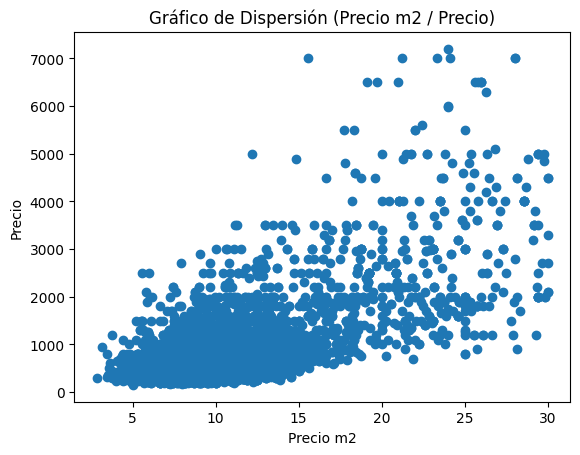

In [445]:
# GRAFICO DE DISPERSON PRECIO M2 / PRECIO

plt.scatter(df_inmuebles['precio_m2'], df_inmuebles['precio'])

plt.title('Gráfico de Dispersión (Precio m2 / Precio)')
plt.xlabel('Precio m2')
plt.ylabel('Precio')

plt.show()

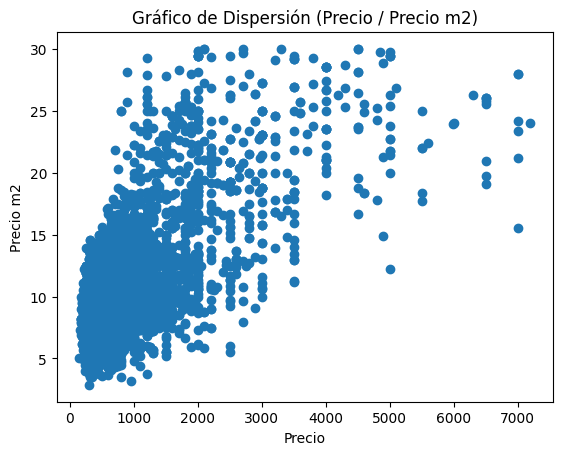

In [446]:
# GRAFICO DE DISPERSON PRECIO / PRECIO M2

plt.scatter(df_inmuebles['precio'], df_inmuebles['precio_m2'])

plt.title('Gráfico de Dispersión (Precio / Precio m2)')
plt.xlabel('Precio')
plt.ylabel('Precio m2')

plt.show()

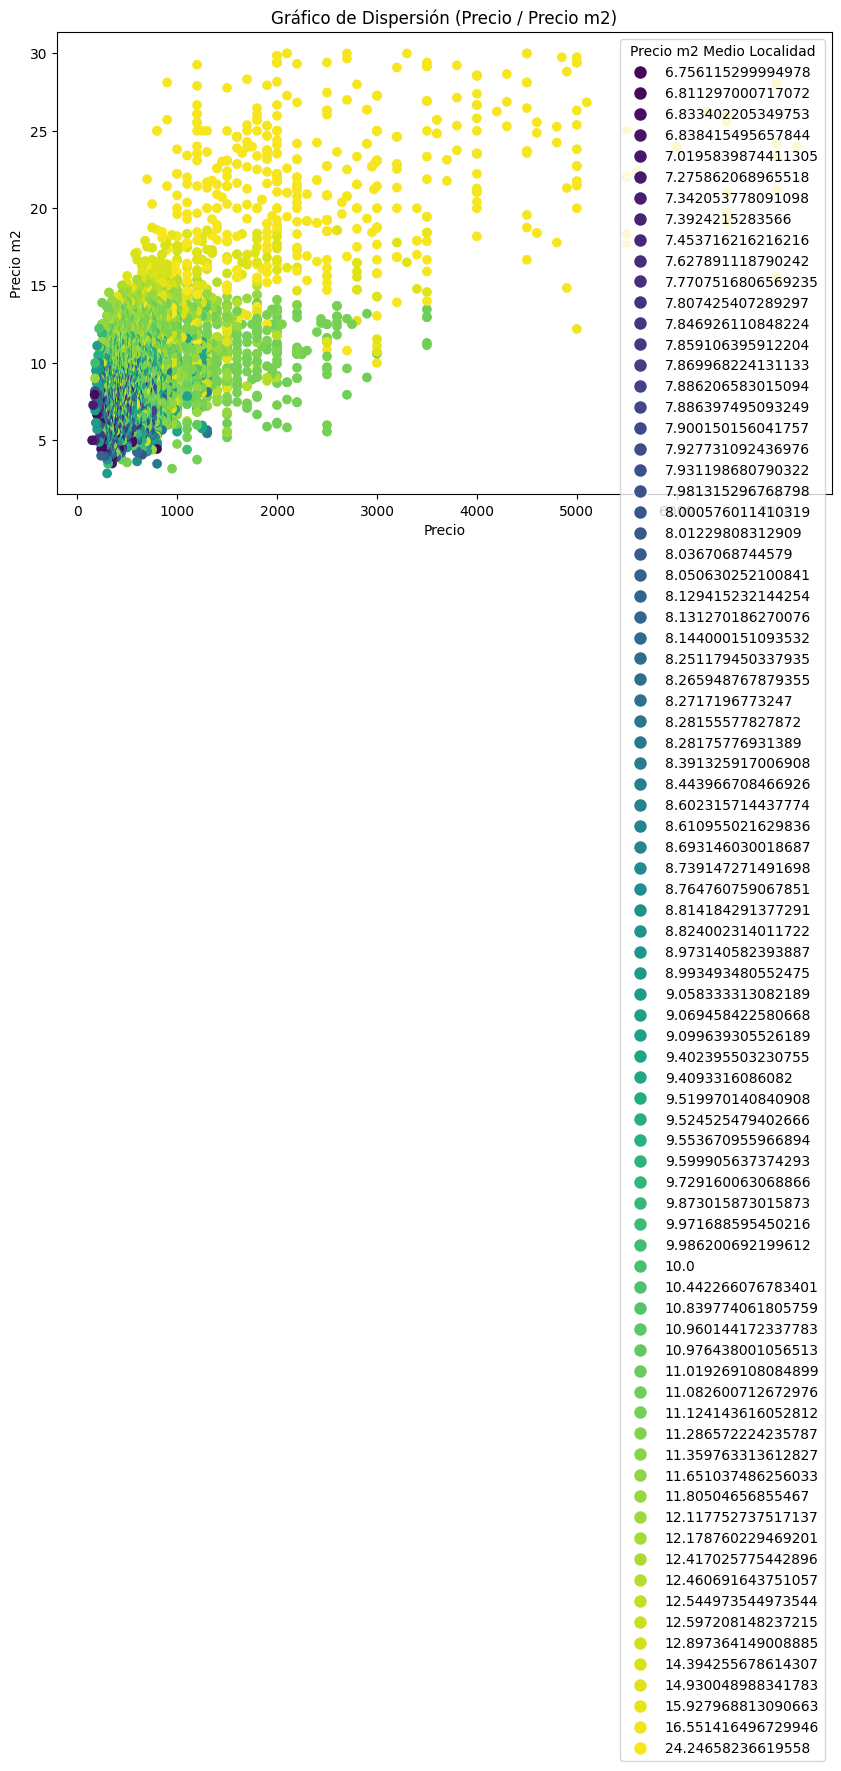

In [447]:
unique_values = np.sort(df_inmuebles['precio_m2_medio_localidad'].unique())
palette = sns.color_palette("viridis", len(unique_values))
color_dict = {value: palette[i] for i, value in enumerate(unique_values)}

# Asignar colores a cada punto
colors = df_inmuebles['precio_m2_medio_localidad'].map(color_dict)

plt.figure(figsize=(10, 6))

# Crear el gráfico de dispersión
plt.scatter(df_inmuebles['precio'], df_inmuebles['precio_m2'], c=colors)

plt.title('Gráfico de Dispersión (Precio / Precio m2)')
plt.xlabel('Precio')
plt.ylabel('Precio m2')

# Crear una leyenda personalizada
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[val], markersize=10) for val in unique_values]
labels = [str(val) for val in unique_values]
plt.legend(handles, labels, title='Precio m2 Medio Localidad')

plt.show()

# MODELOS

In [448]:
df_inmuebles.head()

,precio,superficie_total,superficie_cubierta,cantidad_de_ambiente,cantidad_de_banios,cantidad_de_dormitorios,antiguedad,cantidad_de_cocheras,cantidad_de_toiletes,aire_acondicionado,...,orientacion_SO,luminosidad_Luminoso,luminosidad_Muy luminoso,luminosidad_Poco luminoso,estado_general_Excelente,estado_general_Muy bueno,estado_general_Reciclado,precio_m2,precio_m2_medio_localidad,precio_medio_localidad
6546,7200,300,300,6,5,3,8,2,0,1,...,0,0,0,0,0,0,0,24.000000,24.246582,2731.266876
6549,7000,330,330,5,5,3,8,2,0,1,...,0,0,0,0,0,0,0,21.212121,24.246582,2731.266876
6547,7000,450,260,4,3,3,0,3,1,1,...,0,0,1,0,0,0,0,15.555556,24.246582,2731.266876
6554,7000,250,190,4,5,3,1,2,1,0,...,0,0,0,0,0,0,0,28.000000,24.246582,2731.266876
6551,7000,290,290,4,4,3,6,2,1,0,...,0,0,1,0,0,0,0,24.137931,24.246582,2731.266876


## Cat Boost

In [449]:
X = df_inmuebles.drop('precio', axis=1)
y = df_inmuebles['precio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = cb.CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=5,
    subsample=1.0,
    colsample_bylevel=0.9,
    bagging_temperature=2,
    random_strength=0
    )

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

with open('modelo_entrenado.pkl', 'wb') as file:
    pickle.dump(model, file)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calcula la varianza de los datos objetivo para comparación
varianza_y = np.var(y_test)
print("Varianza: ", varianza_y)

0:	learn: 631.3229423	total: 10.4ms	remaining: 10.4s
1:	learn: 580.2384960	total: 21.1ms	remaining: 10.5s
2:	learn: 533.5104218	total: 31.9ms	remaining: 10.6s
3:	learn: 490.9253987	total: 43.4ms	remaining: 10.8s
4:	learn: 452.9660763	total: 54ms	remaining: 10.7s
5:	learn: 419.1300160	total: 63.8ms	remaining: 10.6s
6:	learn: 387.0905572	total: 75.8ms	remaining: 10.8s
7:	learn: 356.4664516	total: 94.1ms	remaining: 11.7s
8:	learn: 328.7711461	total: 114ms	remaining: 12.6s
9:	learn: 305.5216266	total: 121ms	remaining: 11.9s
10:	learn: 282.2110526	total: 133ms	remaining: 11.9s
11:	learn: 261.5638650	total: 144ms	remaining: 11.8s
12:	learn: 241.4196655	total: 150ms	remaining: 11.4s
13:	learn: 224.2842660	total: 158ms	remaining: 11.1s
14:	learn: 208.4089258	total: 171ms	remaining: 11.2s
15:	learn: 194.2548978	total: 180ms	remaining: 11.1s
16:	learn: 181.2528223	total: 193ms	remaining: 11.1s
17:	learn: 169.3048087	total: 209ms	remaining: 11.4s
18:	learn: 159.3771622	total: 219ms	remaining: 11.


Tabla de Comparación:
          Precio Real ($)  Precio Predicho ($)  Error Absoluto ($)  \
1520           900.000000           899.494706            0.505294   
5921           550.000000           557.504166            7.504166   
4626           360.000000           371.419514           11.419514   
5732           700.000000           698.888101            1.111899   
629            850.000000           834.410416           15.589584   
...                   ...                  ...                 ...   
2884           300.000000           299.581840            0.418160   
2330           250.000000           253.890686            3.890686   
8057           450.000000           456.745560            6.745560   
3674           850.000000           849.367748            0.632252   
Promedio       724.429348           725.310084            8.391001   

          Error Cuadrático ($²)  
1520                   0.255322  
5921                  56.312515  
4626                 130.405300  


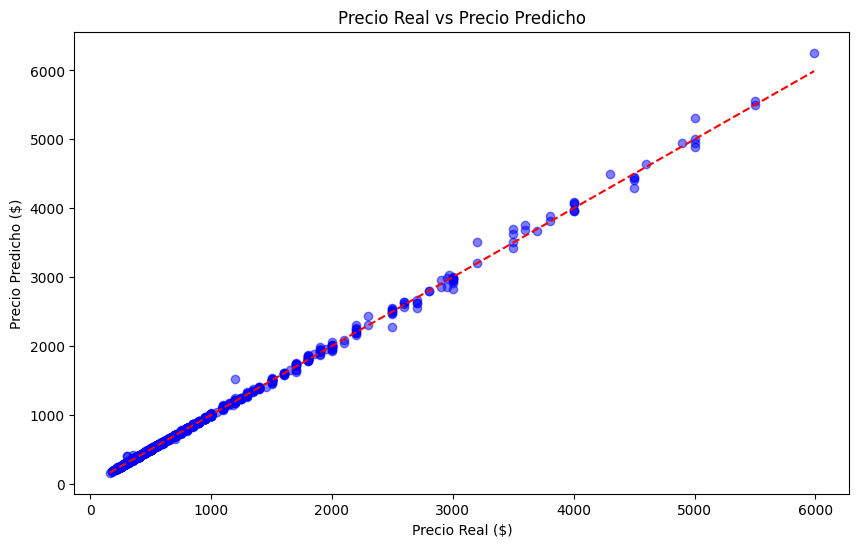

In [450]:
errores_absolutos = [abs(real - pred) for real, pred in zip(y_test, y_pred)]
errores_cuadraticos = [(real - pred)**2 for real, pred in zip(y_test, y_pred)]

df_comparacion = pd.DataFrame({
    'Precio Real ($)': y_test,
    'Precio Predicho ($)': y_pred,
    'Error Absoluto ($)': errores_absolutos,
    'Error Cuadrático ($²)': errores_cuadraticos
})

df_comparacion.loc['Promedio'] = df_comparacion.mean()

print("\nTabla de Comparación:")
print(df_comparacion)

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Precio Real ($)')
plt.ylabel('Precio Predicho ($)')
plt.title('Precio Real vs Precio Predicho')
plt.show()